##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l07c01_saving_and_loading_models.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l07c01_saving_and_loading_models.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

# Saving and Loading Models

In this tutorial we will learn how we can take a trained model, save it, and then load it back to keep training it or use it to perform inference. In particular, we will use transfer learning to train a classifier to classify images of cats and dogs, just like we did in the previous lesson. We will then take our trained model and save it as an HDF5 file, which is the format used by Keras. We will then load this model, use it to perform predictions, and then continue to train the model. Finally, we will save our trained model as a TensorFlow SavedModel and then we will download it to a local disk, so that it can later be used for deployment in different platforms.

## Concepts that will be covered in this Colab

1. Saving models in HDF5 format for Keras
2. Saving models in the TensorFlow SavedModel format
3. Loading models
4. Download models to Local Disk

Before starting this Colab, you should reset the Colab environment by selecting `Runtime -> Reset all runtimes...` from menu above.

# Imports

In this Colab we will use the TensorFlow 2.0 Beta version. 

In [1]:
!pip install -U tensorflow_hub
!pip install -U tensorflow_datasets

Requirement already up-to-date: tensorflow_hub in /usr/local/lib/python3.7/dist-packages (0.12.0)
Requirement already up-to-date: tensorflow_datasets in /usr/local/lib/python3.7/dist-packages (4.3.0)


Some normal imports we've seen before. 

In [2]:
import time
import numpy as np
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from tensorflow.keras import layers

# Part 1: Load the Cats vs. Dogs Dataset

We will use TensorFlow Datasets to load the Dogs vs Cats dataset. 

In [3]:
(train_examples, validation_examples), info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    with_info=True,
    as_supervised=True,
)

The images in the Dogs vs. Cats dataset are not all the same size. So, we need to reformat all images to the resolution expected by MobileNet (224, 224)

In [4]:
def format_image(image, label):
  # `hub` image modules exepct their data normalized to the [0,1] range.
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return  image, label

num_examples = info.splits['train'].num_examples

BATCH_SIZE = 32
IMAGE_RES = 224

train_batches      = train_examples.cache().shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.cache().map(format_image).batch(BATCH_SIZE).prefetch(1)

# Part 2: Transfer Learning with TensorFlow Hub

We will now use TensorFlow Hub to do Transfer Learning.

In [5]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES,3))

Freeze the variables in the feature extractor layer, so that the training only modifies the final classifier layer.

In [6]:
feature_extractor.trainable = False

## Attach a classification head

Now wrap the hub layer in a `tf.keras.Sequential` model, and add a new classification layer.

In [7]:
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(2)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


## Train the model

We now train this model like any other, by first calling `compile` followed by `fit`.

In [8]:
model.compile(
  optimizer='adam', 
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 1
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

582/582 [==============================] - 625s 1s/step - loss: 0.0536 - accuracy: 0.9810 - val_loss: 0.0364 - val_accuracy: 0.9875


## Check the predictions

Get the ordered list of class names.

In [9]:
class_names = np.array(info.features['label'].names)
class_names

array(['cat', 'dog'], dtype='<U3')

Run an image batch through the model and convert the indices to class names.

In [10]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

array(['dog', 'cat', 'dog', 'cat', 'dog', 'cat', 'cat', 'dog', 'cat',
       'cat', 'dog', 'dog', 'cat', 'dog', 'dog', 'cat', 'dog', 'cat',
       'dog', 'dog', 'dog', 'dog', 'dog', 'cat', 'cat', 'cat', 'dog',
       'dog', 'dog', 'cat', 'cat', 'cat'], dtype='<U3')

Let's look at the true labels and predicted ones.

In [11]:
print("Labels: ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:  [1 0 1 0 1 0 0 1 0 0 1 1 0 1 1 0 1 0 1 1 1 1 1 0 0 0 1 1 1 0 0 0]
Predicted labels:  [1 0 1 0 1 0 0 1 0 0 1 1 0 1 1 0 1 0 1 1 1 1 1 0 0 0 1 1 1 0 0 0]


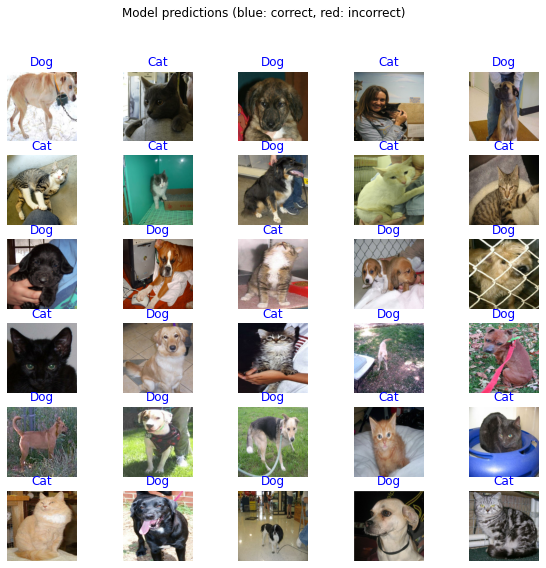

In [12]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

# Part 3: Save as Keras `.h5` model

Now that we've trained the model,  we can save it as an HDF5 file, which is the format used by Keras. Our HDF5 file will have the extension '.h5', and it's name will correpond to the current time stamp.

In [13]:
t = time.time()

export_path_keras = "./{}.h5".format(int(t))
print(export_path_keras)

model.save(export_path_keras)

./1623498118.h5


In [14]:
!ls

1623498118.h5  sample_data


 You can later recreate the same model from this file, even if you no longer have access to the code that created the model.

This file includes:

- The model's architecture
- The model's weight values (which were learned during training)
- The model's training config (what you passed to `compile`), if any
- The optimizer and its state, if any (this enables you to restart training where you left off)

# Part 4:  Load the Keras `.h5` Model

We will now load the model we just saved into a new model called `reloaded`. We will need to provide the file path and the `custom_objects` parameter. This parameter tells keras how to load the `hub.KerasLayer` from the `feature_extractor` we used for transfer learning.

In [15]:
reloaded = tf.keras.models.load_model(
  export_path_keras, 
  # `custom_objects` tells keras how to load a `hub.KerasLayer`
  custom_objects={'KerasLayer': hub.KerasLayer})

reloaded.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


We can check that the reloaded model and the previous model give the same result

In [16]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

The difference in output should be zero:

In [17]:
(abs(result_batch - reloaded_result_batch)).max()

0.0

As we can see, the reult is 0.0, which indicates that both models made the same predictions on the same batch of images.

# Keep Training

Besides making predictions, we can also take our `reloaded` model and keep training it. To do this, you can just train the `reloaded` as usual, using the `.fit` method.

In [19]:
EPOCHS = 1
history = reloaded.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

582/582 [==============================] - 607s 1s/step - loss: 0.0296 - accuracy: 0.9897 - val_loss: 0.0348 - val_accuracy: 0.9875


# Part 5: Export as SavedModel


You can also export a whole model to the TensorFlow SavedModel format. SavedModel is a standalone serialization format for Tensorflow objects, supported by TensorFlow serving as well as TensorFlow implementations other than Python. A SavedModel contains a complete TensorFlow program, including weights and computation. It does not require the original model building code to run, which makes it useful for sharing or deploying (with TFLite, TensorFlow.js, TensorFlow Serving, or TFHub).

The SavedModel files that were created contain:

* A TensorFlow checkpoint containing the model weights.
* A SavedModel proto containing the underlying Tensorflow graph. Separate graphs are saved for prediction (serving), train, and evaluation. If the model wasn't compiled before, then only the inference graph gets exported.
* The model's architecture config, if available.


Let's save our original `model` as a TensorFlow SavedModel. To do this we will use the `tf.saved_model.save()` function. This functions takes in the model we want to save and the path to the folder where we want to save our model. 

This function will create a folder where you will find an `assets` folder, a `variables` folder, and the `saved_model.pb` file. 

In [20]:
t = time.time()

export_path_sm = "./{}".format(int(t))
print(export_path_sm)

tf.saved_model.save(model, export_path_sm)

./1623498923

FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


INFO:tensorflow:Assets written to: ./1623498923/assets


INFO:tensorflow:Assets written to: ./1623498923/assets


In [21]:
!ls {export_path_sm}

assets	saved_model.pb	variables


# Part 6: Load SavedModel

Now, let's load our SavedModel and use it to make predictions. We use the `tf.saved_model.load()` function to load our SavedModels. The object returned by `tf.saved_model.load` is 100% independent of the code that created it.

In [22]:
reloaded_sm = tf.saved_model.load(export_path_sm)

Now, let's use the `reloaded_sm` (reloaded SavedModel) to make predictions on a batch of images.

In [23]:
reload_sm_result_batch = reloaded_sm(image_batch, training=False).numpy()

We can check that the reloaded SavedModel and the previous model give the same result.

In [24]:
(abs(result_batch - reload_sm_result_batch)).max()

0.0

As we can see, the result is 0.0, which indicates that both models made the same predictions on the same batch of images.

# Part 7: Loading the SavedModel as a Keras Model

The object returned by `tf.saved_model.load` is not a Keras object (i.e. doesn't have `.fit`, `.predict`, `.summary`, etc. methods). Therefore, you can't simply take your `reloaded_sm` model and keep training it by running `.fit`. To be able to get back a full keras model from the Tensorflow SavedModel format we must use the `tf.keras.models.load_model` function. This function will work the same as before, except now we pass the path to the folder containing our SavedModel.

In [25]:
t = time.time()

export_path_sm = "./{}".format(int(t))
print(export_path_sm)
tf.saved_model.save(model, export_path_sm)

./1623499000

FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


INFO:tensorflow:Assets written to: ./1623499000/assets


INFO:tensorflow:Assets written to: ./1623499000/assets


In [26]:
reload_sm_keras = tf.keras.models.load_model(
  export_path_sm,
  custom_objects={'KerasLayer': hub.KerasLayer})

reload_sm_keras.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


Now, let's use the `reloaded_sm)keras` (reloaded Keras model from our SavedModel) to make predictions on a batch of images.

In [27]:
result_batch = model.predict(image_batch)
reload_sm_keras_result_batch = reload_sm_keras.predict(image_batch)

We can check that the reloaded Keras model and the previous model give the same result.

In [28]:
(abs(result_batch - reload_sm_keras_result_batch)).max()

0.0

# Part 8:  Download your model

You can download the SavedModel to your local disk by creating a zip file. We wil use the `-r` (recursice) option to zip all subfolders. 

In [29]:
!zip -r model.zip {export_path_sm}

  adding: 1623499000/ (stored 0%)
  adding: 1623499000/saved_model.pb (deflated 92%)
  adding: 1623499000/assets/ (stored 0%)
  adding: 1623499000/variables/ (stored 0%)
  adding: 1623499000/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: 1623499000/variables/variables.index (deflated 78%)


The zip file is saved in the current working directory. You can see what the current working directory is by running:

In [30]:
!ls

1623498118.h5  1623498923  1623499000  model.zip  sample_data


Once the file is zipped, you can download  it to your local disk. 

In [31]:
try:
  from google.colab import files
  files.download('./model.zip')
except ImportError:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The `files.download` command will  search for files in your current working directory. If the file you want to download is in a directory other than the current working directory, you have to include the path to the directory where the file is located.